In [1]:
import geopandas as gpd
import numpy as np

# Load the dataset
cellular_data = gpd.read_file("cellular_data_with_cgsa_distance.geojson")

# Define weights for each feature (adjust based on your priorities)
weights = {
    'raw_population_density': 0.4,
    'population_weighted_density_sub': 0.3,
    'distance_to_nearest_tower_km': -0.2,  # Negative weight because closer is better
    'elevation': -0.05,  # Negative weight because lower elevation is better
    'slope': -0.05  # Negative weight because lower slope is better
}

# Create a target variable (suitability score)
cellular_data['suitability_score'] = (
    weights['raw_population_density'] * cellular_data['raw_population_density'] +
    weights['population_weighted_density_sub'] * cellular_data['population_weighted_density_sub'] +
    weights['distance_to_nearest_tower_km'] * cellular_data['distance_to_nearest_tower_km'] +
    weights['elevation'] * cellular_data['elevation'] +
    weights['slope'] * cellular_data['slope']
)

# Normalize the suitability score to a range of 0 to 100
cellular_data['suitability_score'] = (
    (cellular_data['suitability_score'] - cellular_data['suitability_score'].min()) /
    (cellular_data['suitability_score'].max() - cellular_data['suitability_score'].min()) * 100
)

# Check the updated dataset
print(cellular_data[['geometry', 'suitability_score']].head())

                                            geometry  suitability_score
0  POLYGON ((-122.35358 47.68378, -122.35363 47.6...          94.189970
1  POLYGON ((-122.70528 47.69111, -122.70533 47.6...          94.244084
2  POLYGON ((-122.52389 47.48028, -122.52394 47.4...          94.221633
3  POLYGON ((-122.81167 47.692, -122.81171 47.691...          94.213209
4  POLYGON ((-122.56217 47.51708, -122.56221 47.5...          94.229555


In [2]:
print(cellular_data.dtypes)

FID                                     int32
UniqSysID                               int32
Licensee                               object
Callsign                               object
LocNum                                  int32
LatDeg                                  int32
LatMin                                  int32
LatSec                                float64
LatDir                                 object
LonDeg                                  int32
LonMin                                  int32
LonSec                                float64
LonDir                                 object
LocAdd                                 object
LocCity                                object
LocCounty                              object
LocState                               object
Nepa                                   object
QZone                                  object
TowReg                                  int32
SupStruc                              float64
AllStruc                          

In [4]:
import pandas as pd

In [5]:
# Convert object columns to numeric
cellular_data['population_weighted_density_left'] = pd.to_numeric(cellular_data['population_weighted_density_left'], errors='coerce')
cellular_data['population_weighted_density_right'] = pd.to_numeric(cellular_data['population_weighted_density_right'], errors='coerce')

In [6]:
# Define the columns you want to use
relevant_columns = [
    'elevation', 'slope',
    'raw_population_density',
    'population_weighted_density_left', 'population_weighted_density_right', 'population_weighted_density_sub',
    'distance_to_nearest_tower_meters', 'distance_to_nearest_tower_km',
    'suitability_score'
]

# Create a subset of the dataset
cellular_data_subset = cellular_data[relevant_columns].copy()

In [7]:
# Convert object columns to numeric
cellular_data_subset['population_weighted_density_left'] = pd.to_numeric(
    cellular_data_subset['population_weighted_density_left'], errors='coerce'
)
cellular_data_subset['population_weighted_density_right'] = pd.to_numeric(
    cellular_data_subset['population_weighted_density_right'], errors='coerce'
)

In [8]:
# Check for missing values
print(cellular_data_subset.isnull().sum())

# Fill missing values with the mean
cellular_data_subset = cellular_data_subset.fillna(cellular_data_subset.mean())

elevation                               0
slope                                   0
raw_population_density               1239
population_weighted_density_left     5770
population_weighted_density_right    5770
population_weighted_density_sub         0
distance_to_nearest_tower_meters        0
distance_to_nearest_tower_km            0
suitability_score                    1239
dtype: int64


In [9]:
print(cellular_data_subset.dtypes)

elevation                            float64
slope                                float64
raw_population_density               float64
population_weighted_density_left     float64
population_weighted_density_right    float64
population_weighted_density_sub      float64
distance_to_nearest_tower_meters     float64
distance_to_nearest_tower_km         float64
suitability_score                    float64
dtype: object


In [10]:
!pip install xgboost

  Using cached xgboost-3.0.0-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached nvidia_nccl_cu12-2.26.2-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-3.0.0-py3-none-manylinux_2_28_x86_64.whl (253.9 MB)
Using cached nvidia_nccl_cu12-2.26.2-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (201.3 MB)


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Define features and target
features = [
    'elevation', 'slope',
    'raw_population_density',
    'population_weighted_density_left', 'population_weighted_density_right', 'population_weighted_density_sub',
    'distance_to_nearest_tower_meters', 'distance_to_nearest_tower_km'
]
X = cellular_data_subset[features]
y = cellular_data_subset['suitability_score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost regressor
model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Use 'reg:squarederror' for regression
    n_estimators=100,              # Number of trees
    max_depth=5,                   # Maximum depth of each tree
    learning_rate=0.1,             # Learning rate
    subsample=0.8,                 # Subsample ratio of the training instances
    colsample_bytree=0.8,          # Subsample ratio of columns when constructing each tree
    random_state=42,               # Random seed for reproducibility
    n_jobs=-1                      # Use all available CPU cores
)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.48716194772626564
R^2 Score: 0.9996339766261076


In [13]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.2 MB/s eta 0:00:00


In [14]:
import shap

# Initialize SHAP explainer
explainer = shap.Explainer(model)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

/opt/conda/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1437: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


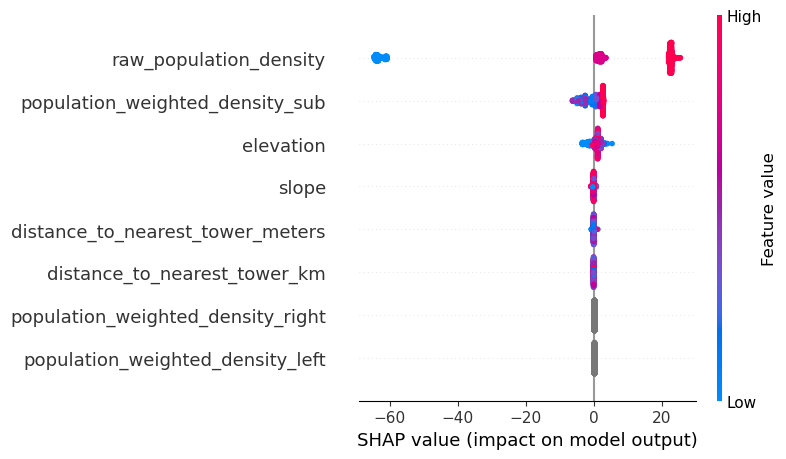

In [15]:
# Plot SHAP summary
shap.summary_plot(shap_values, X_test)

/opt/conda/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1437: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


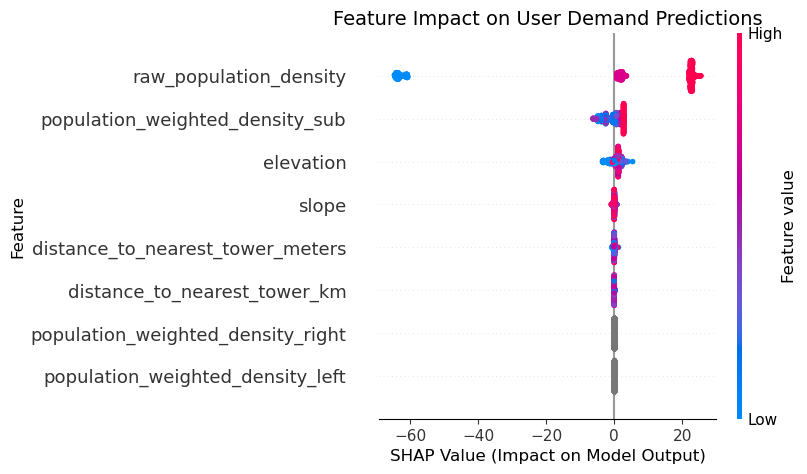

In [17]:
import matplotlib.pyplot as plt

# Create SHAP summary plot
shap.summary_plot(shap_values, X_test, show=False)

# Add title and labels
plt.title("Feature Impact on User Demand Predictions", fontsize=14)
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
plt.ylabel("Feature", fontsize=12)

# Show plot
plt.show()

In [13]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Cross-Validation R² Scores:", cv_scores)
print("Mean Cross-Validation R² Score:", cv_scores.mean())

Cross-Validation R² Scores: [0.99971484 0.99967238 0.99965516 0.99975452 0.99944171]
Mean Cross-Validation R² Score: 0.9996477201602806


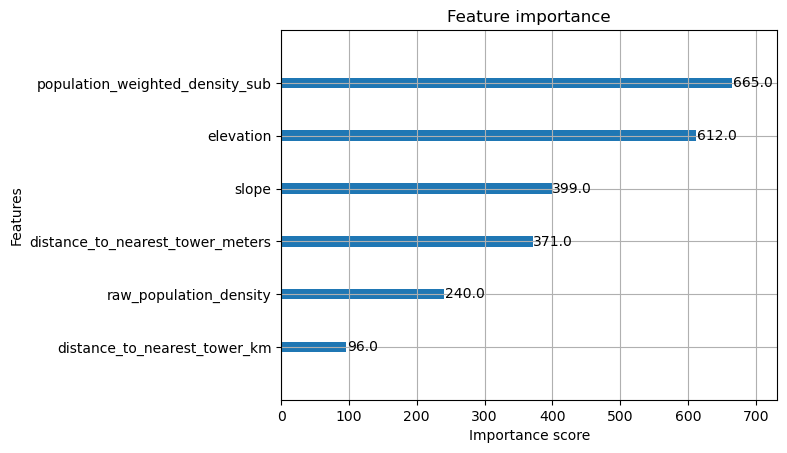

In [14]:
import matplotlib.pyplot as plt

xgb.plot_importance(model)
plt.show()

In [16]:
#I don't have a validation set (silly me) so I'm trying to train a simpler model to check for overfitting.
# Initialize a simpler XGBoost regressor
simple_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=50,  # Fewer trees
    max_depth=3,       # Shallower trees
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,     # L1 regularization
    reg_lambda=1.0,    # L2 regularization
    random_state=42,
    n_jobs=-1
)

# Train the simpler model
simple_model.fit(X_train, y_train)

# Evaluate the simpler model
y_pred_simple = simple_model.predict(X_test)
mse_simple = mean_squared_error(y_test, y_pred_simple)
r2_simple = r2_score(y_test, y_pred_simple)
print(f"Simpler Model Mean Squared Error: {mse_simple}")
print(f"Simpler Model R^2 Score: {r2_simple}")

Simpler Model Mean Squared Error: 1.4408740000521965
Simpler Model R^2 Score: 0.9989174163431392


In [17]:
# Predict suitability scores for all locations
cellular_data['predicted_suitability_score'] = model.predict(X)

# Rank locations by predicted suitability score
ranked_locations = cellular_data.sort_values(by='predicted_suitability_score', ascending=False)

# Display the top 10 locations
print(ranked_locations[['geometry', 'predicted_suitability_score']].head(10))

# Save the ranked locations to a new GeoJSON file
ranked_locations.to_file("ranked_cell_tower_locations.geojson", driver="GeoJSON")

                                               geometry  \
2938  POLYGON ((-121.85392 43.47042, -121.85396 43.4...   
4593  POLYGON ((-121.85389 43.47069, -121.85394 43.4...   
3358  POLYGON ((-109.43689 42.24439, -109.43694 42.2...   
3380  POLYGON ((-109.61217 41.58542, -109.61221 41.5...   
3373  POLYGON ((-109.68747 42.66814, -109.68752 42.6...   
1461  POLYGON ((-122.95542 46.66844, -122.95546 46.6...   
3374  POLYGON ((-109.79869 41.61947, -109.79874 41.6...   
2187  POLYGON ((-108.96194 39.21569, -108.96199 39.2...   
3050  POLYGON ((-111.84722 39.6525, -111.84727 39.65...   
1851  POLYGON ((-121.62689 36.84994, -121.62694 36.8...   

      predicted_suitability_score  
2938                    98.735771  
4593                    98.735771  
3358                    98.596794  
3380                    98.126884  
3373                    97.703270  
1461                    97.441483  
3374                    97.240860  
2187                    97.083099  
3050                    97

In [18]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation on the simpler model
cv_scores = cross_val_score(simple_model, X, y, cv=5, scoring='r2')
print("Cross-Validation R² Scores:", cv_scores)
print("Mean Cross-Validation R² Score:", cv_scores.mean())

Cross-Validation R² Scores: [0.99898091 0.99893704 0.99864985 0.99898766 0.99826489]
Mean Cross-Validation R² Score: 0.9987640690040157


In [19]:
# Evaluate the simpler model on the training set
y_pred_train = simple_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
print(f"Training Mean Squared Error: {mse_train}")
print(f"Training R^2 Score: {r2_train}")

# Evaluate the simpler model on the test set
y_pred_test = simple_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"Test Mean Squared Error: {mse_test}")
print(f"Test R^2 Score: {r2_test}")

Training Mean Squared Error: 1.1893736041940997
Training R^2 Score: 0.9991377077441471
Test Mean Squared Error: 1.4408740000521965
Test R^2 Score: 0.9989174163431392


In [20]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=simple_model,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)

# Perform Grid Search
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best Parameters:", grid_search.best_params_)

# Train the model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Evaluate the best model
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
print(f"Best Model Mean Squared Error: {mse_best}")
print(f"Best Model R^2 Score: {r2_best}")

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150, 'subsample': 1.0}
Best Model Mean Squared Error: 0.006837369618993699
Best Model R^2 Score: 0.9999948628231162
